# Craigslist Car Price Prediction

**Epistolary Acumen**

In this notebook we will build a model that predicts car price using numeric and categorical features, as well as some minor text ones. The dataset, put together by Austin Reese (https://www.kaggle.com/austinreese/craigslist-carstrucks-data), consists of cars posted on craigslist that were for sale in the United States.

**Road Map**
-  Data Cleaning
-  Feature Engineering
-  Model

In [1]:
#Import libraries and read in dataset

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

df = pd.read_csv('craigslistVehicles.csv')

In [2]:
df.shape

(443405, 22)

In [3]:
df.iloc[0]

url             https://albuquerque.craigslist.org/cto/d/albuq...
city                                                  albuquerque
city_url                       https://albuquerque.craigslist.org
price                                                        1500
year                                                         2005
manufacturer                                              hyundai
make                                                      elantra
condition                                                    good
cylinders                                             4 cylinders
fuel                                                          gas
odometer                                                   256000
title_status                                                clean
transmission                                            automatic
VIN                                                           NaN
drive                                                         fwd
size      

In [4]:
df.describe()

,price,year,odometer,lat,long
count,4.434050e+05,442625.000000,3.506140e+05,442580.000000,442580.000000
mean,1.341564e+05,2008.227000,1.032847e+05,38.314511,-93.749928
std,1.856712e+07,9.903604,1.233734e+05,5.841092,17.419178
min,0.000000e+00,1900.000000,0.000000e+00,-75.930065,-159.719900
25%,3.795000e+03,2005.000000,4.880825e+04,34.575600,-105.085420
50%,8.948000e+03,2010.000000,9.600000e+04,39.018700,-88.167289
75%,1.699100e+04,2014.000000,1.409090e+05,42.175851,-80.723560
max,4.173654e+09,2020.000000,1.000000e+07,81.660473,164.397354


**Observations**

Notice some oddities in the price field. We have extreme values that will harm our model as well as values of 0 that do not make sense.

In [5]:
df['price'].value_counts().sort_index(ascending=False).head(5)

4173653755     1
3700093123     1
2983521604    12
2860372403     1
1234567890     1
Name: price, dtype: int64

**Data Cleaning**

Let's start by nuking these outliers.

In [6]:
print(df.price.quantile(.95))
print(df.price.quantile(.99))
print(df.price.quantile(.999))
print(df.price.quantile(.9995))

33950.0
49998.0
98000.0
135000.0


In [7]:
df = df[df.price >1000] #nuke the cars with price <1000 (arbitrary)
df = df[df.price < 200000] # 200,000 is a reasonable cap

In [8]:
df.shape

(388384, 22)

**Drop columns not needed for machine learning.**

In [9]:
df.drop(['url', 'city', 'city_url','VIN','image_url', 'lat', 'long'],axis=1,inplace=True)

**For non numerical columns, let's drop ones that are not feasible to use as dummy variables.**

In [10]:
cat_col = df.select_dtypes(include=['object'])
cat_col.drop('desc',inplace=True,axis=1) #we will not dummy the description field
uniqueness_counts = cat_col.apply(lambda col: len(col.value_counts())).sort_values()
uniqueness_counts

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


transmission        3
drive               3
size                4
fuel                5
condition           6
title_status        6
cylinders           8
paint_color        12
type               13
manufacturer       42
make            39264
dtype: int64

**We'll do our cutoff at <14 categories.**

In [11]:
df.drop(['manufacturer','make'],axis=1,inplace=True)

**Now lets look at missing data.**

In [12]:
l = []

for column in df:
    pct = (df[column].count())/len(df[column])
    l.append(pct)
dict = {'Column': df.columns.tolist(), 'Percent': l}  
fill_pct = pd.DataFrame(dict)
fill_pct.sort_values(by=['Percent'],ascending=False)

,Column,Percent
0,price,1.000000
12,desc,0.999972
1,year,0.998048
6,title_status,0.995033
7,transmission,0.992940
4,fuel,0.990893
5,odometer,0.801627
8,drive,0.705696
10,type,0.705577
11,paint_color,0.680061


**I hazard that condition is important so we will set a cutoff that enables keeping it.**

In [13]:
df.drop('size',axis=1,inplace=True)

In [14]:
print(df.shape)
print(df.dropna().shape)

(388384, 12)
(116513, 12)


**Quite the data loss. Do we gain much by imputing values on the fields we _can_ impute?**

In [15]:
x = df.copy()

x['odometer'].fillna((x['odometer'].mean()), inplace=True)
x.dropna().shape

(132838, 12)

**Let's settle for 132k observations for now.**

In [16]:
df['odometer'].fillna((df['odometer'].mean()), inplace=True)

In [17]:
df.dropna(inplace=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132838 entries, 0 to 443402
Data columns (total 12 columns):
price           132838 non-null int64
year            132838 non-null float64
condition       132838 non-null object
cylinders       132838 non-null object
fuel            132838 non-null object
odometer        132838 non-null float64
title_status    132838 non-null object
transmission    132838 non-null object
drive           132838 non-null object
type            132838 non-null object
paint_color     132838 non-null object
desc            132838 non-null object
dtypes: float64(2), int64(1), object(9)
memory usage: 13.2+ MB


**Make dummy variables out of these objects.**

In [19]:
text_cols = df.select_dtypes(include=['object']).columns
text_cols.tolist()
t = text_cols.drop('desc') #Do NOT dummy the description column
dummy_cols = pd.DataFrame()
for col in t:
    col_dummies = pd.get_dummies(df[col])
    df = pd.concat([df, col_dummies], axis=1)
    del df[col]

**Description Features**

Lastly, let us add in a few features taken from the description column that one might expect correlate with price. Some that come to mind are 'new', 'used', 'needs', 'good' and 'great'. 

These are very arbitrary but they just might help our model.

In [23]:
def d_word(word,df):
    word_list=[]    
    for row in df['desc']: 
        if word in row:
            word_list.append(1)
        else:
            word_list.append(0)
    df[word] = word_list

In [25]:
d_word('new',df)
d_word('used',df)
d_word('needs',df)
d_word('good',df)
d_word('great',df)

In [26]:
df.head(1)

,price,year,odometer,desc,excellent,fair,good,like new,new,salvage,...,grey,orange,purple,red,silver,white,yellow,used,needs,great
0,1500,2005.0,256000.0,Selling a 2005 Hyundai Elantra 2.0 4 cylinder....,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Linear Regression**

In [27]:
from sklearn.model_selection import train_test_split

In [40]:
X=df.drop(['price','desc'],axis=1)
y=df['price']

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=101)

Text(0.5, 1.0, 'Residual vs Predicted')

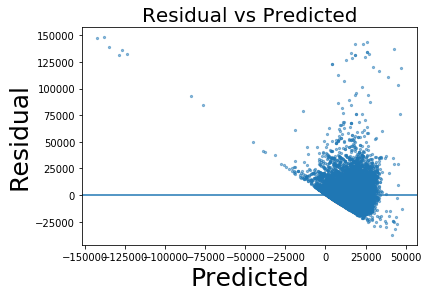

In [41]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(X_train, Y_train)

predicted = lm.predict(X_test)
residual = Y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [42]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

rmse = np.sqrt(mean_squared_error(Y_test, predicted))

print(rmse)
print(r2_score(Y_test, predicted))

8476.452860164107
0.36166729724993596


**Graph Behavior**

Notice how there is a pattern in the residual plot. This stems from the fact that there are many duplicated prices (13 instances of 1050 dollars, 184 instances of 1100...). We explore how this rounding skews the graph and how to correct it here (https://github.com/EpistolaryAcumen/Craigslist-Car-Price-Prediction/blob/master/Residual%20Plot%20Anomaly.ipynb) but becuase 'fixing' the issue results in massive data loss, we will proceed. 

**KNN**

Text(0.5, 1.0, 'Residual vs Predicted')

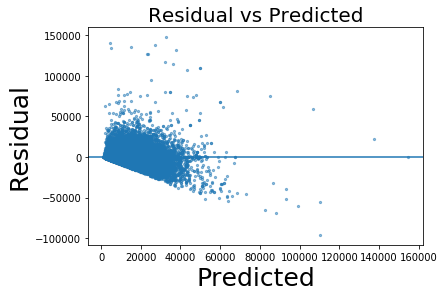

In [43]:
from sklearn import neighbors

knn = neighbors.KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, Y_train)

predicted = knn.predict(X_test)
residual = Y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [44]:
rmse = np.sqrt(mean_squared_error(Y_test, predicted))

print(rmse)
print(r2_score(Y_test, predicted))

7904.16164135107
0.44495215806975774


**Decision Tree**

Text(0.5, 1.0, 'Residual vs Predicted')

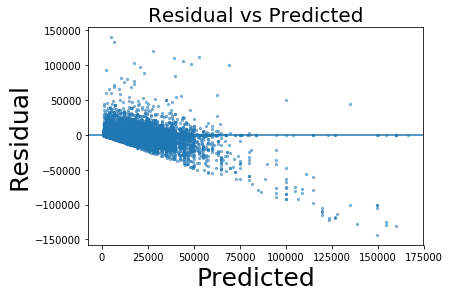

In [45]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(max_features='auto')
dtr.fit(X_train, Y_train)

predicted = dtr.predict(X_test)
residual = Y_test - predicted

plt.scatter(predicted, residual,s=5,alpha=.5)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs Predicted',fontsize=20)

In [46]:
rmse = np.sqrt(mean_squared_error(Y_test, predicted))

print(rmse)
print(r2_score(Y_test, predicted))

6789.388290604631
0.5904753136473535


# Conclusion

Using a decision tree, we were able to obtain the lowest MSE of 6789 dollars and a variance score just under .6.